/tmp/ipykernel_9806/2810850396.py:24: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(buf)


  Time RelSpend-Z   dTime-Z GeoJump-Z Log-Amount POS-ModeRisk  MCC-Risk  \
0  0.0  -1.359807 -0.072781  2.536347   1.378155    -0.338321  0.462388   
1  0.0   1.191857  0.266151   0.16648   0.448154     0.060018 -0.082361   
2  1.0  -1.358354 -1.340163  1.773209    0.37978    -0.503198  1.800499   
3  1.0  -0.966272 -0.185226  1.792993  -0.863291    -0.010309  1.247203   
4  2.0  -1.158233  0.877737  1.548718   0.403034    -0.407193  0.095921   

  Device-Risk  Lon-Jump  Lat-Jump  ...  TxnSim-3 RollSpend-24h RollSpend-7d  \
0    0.239599  0.098698  0.363787  ... -0.018307      0.277838    -0.110474   
1   -0.078803  0.085102 -0.255425  ... -0.225775     -0.638672     0.101288   
2    0.791461  0.247676 -1.514654  ...  0.247998      0.771679     0.909412   
3    0.237609  0.377436 -1.387024  ...   -0.1083      0.005274    -0.190321   
4    0.592941 -0.270533  0.817739  ... -0.009431      0.798278    -0.137458   

  RollSpend-30d  SoftBL-1  SoftBL-2 Manual-Review Chargeback-Flag  Amount 

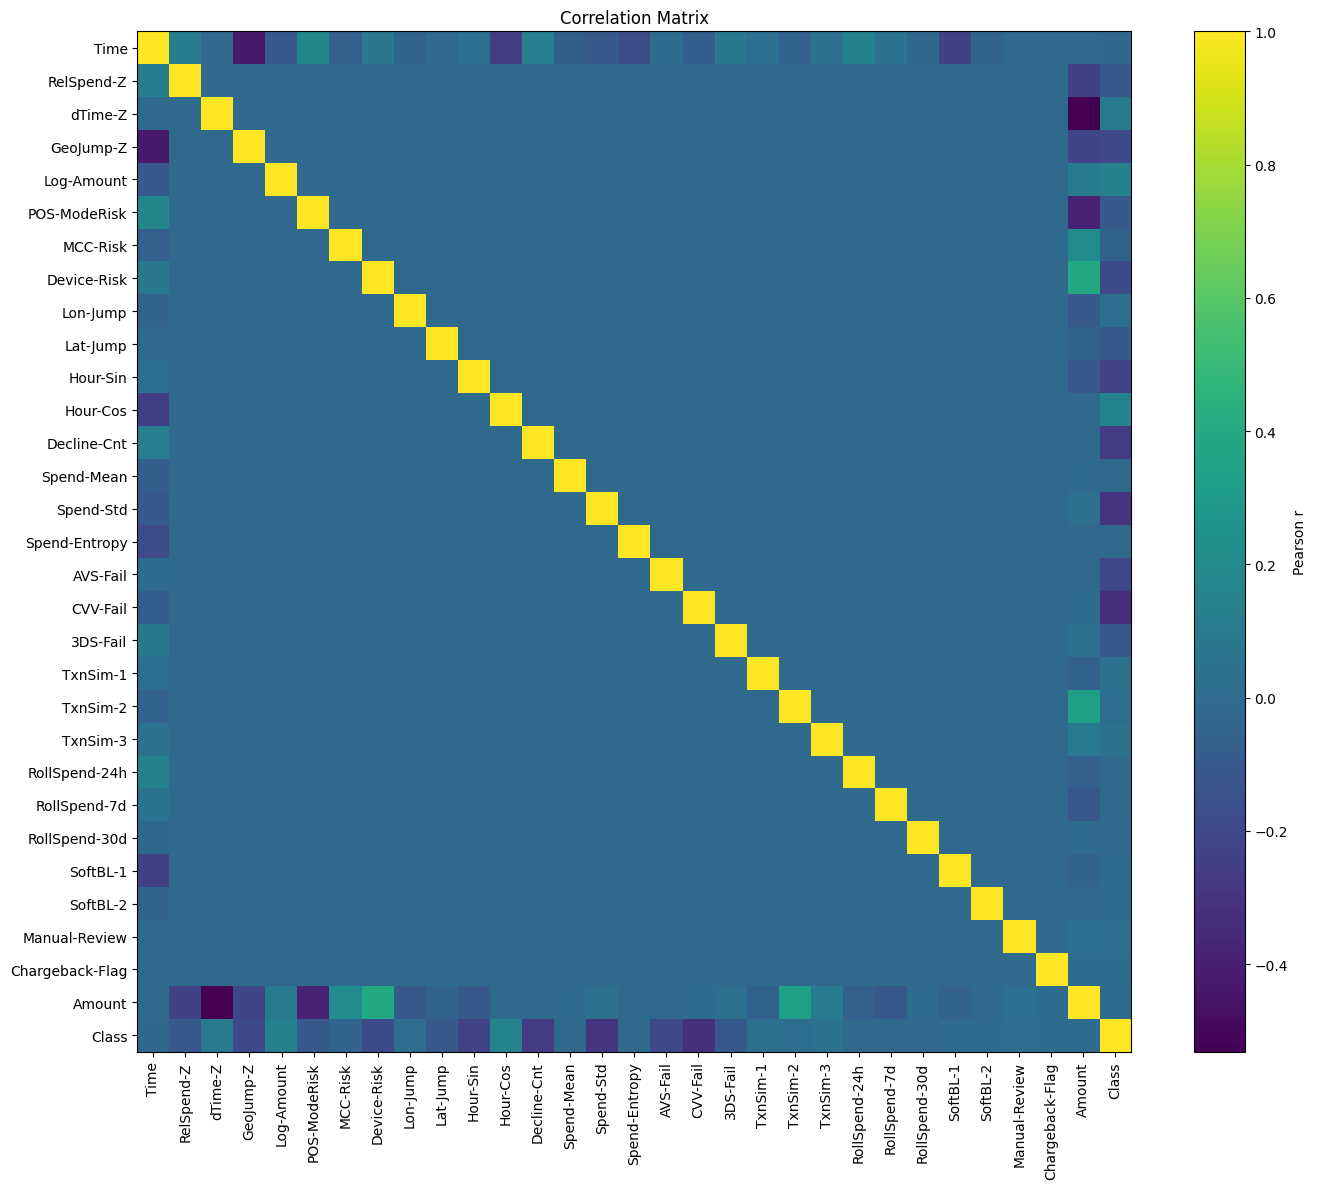

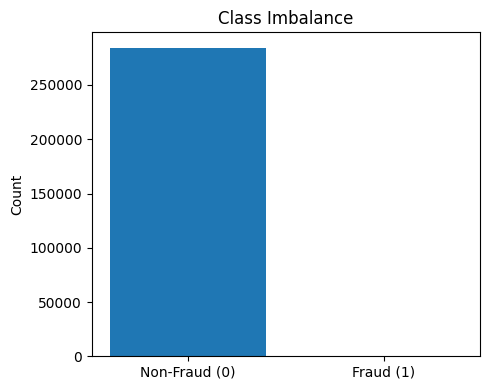

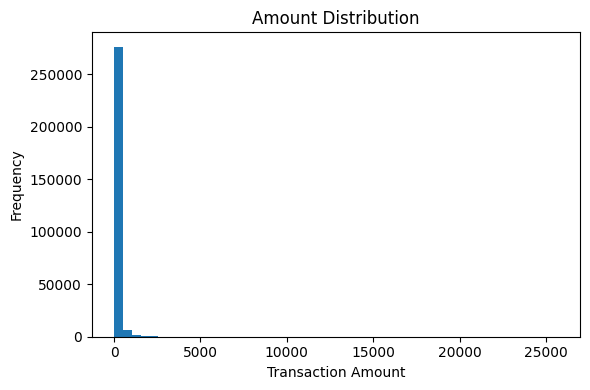

In [12]:
import io, os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

from domino.data_sources import DataSourceClient
from domino_data.datasets import DatasetClient


domino_working_dir = os.environ.get("DOMINO_WORKING_DIR", ".").replace('code', 'data')
domino_project_name = os.environ.get("DOMINO_PROJECT_NAME", "my-local-project")

def clean_and_save_cc_file(raw_filename: str, clean_filename: str):
    # Load with force numeric, bad values → NaN
    object_store = DataSourceClient().get_datasource("credit_card_fraud_detection")
    
    # Stream to in-memory buffer
    buf = io.BytesIO()
    object_store.download_fileobj(raw_filename, buf)
    buf.seek(0)
    
    # Read into DataFrame in-memory
    df_raw = pd.read_csv(buf)
    
    print(df_raw.head())

    # Coerce all columns to numeric, invalid strings become NaN
    df_numeric = df_raw.apply(pd.to_numeric, errors='coerce')

    # Keep rows with no NaN anywhere
    mask = df_numeric.notna().all(axis=1)
    df_cleaned = df_numeric[mask]
    full_path = f"{domino_working_dir}/{domino_project_name}/{clean_filename}"
    df_cleaned.to_csv(full_path, index=False)
    df = df_cleaned
    print(f"✅ Cleaned data saved to: {clean_filename}. Removed {len(df_raw) - len(df_cleaned)} rows")

    overview = pd.DataFrame({
        'n_rows': [df.shape[0]],
        'n_cols': [df.shape[1]]
    })
    print("\n=== Dataset Overview ===")
    print(overview.to_string(index=False))
    
    # 2b) Missing‐value drill‐down
    missing = df.isna().sum().to_frame('missing_count')
    missing['missing_pct'] = 100 * missing['missing_count'] / df.shape[0]
    print("\n=== Missing Values by Column (%) ===")
    print(missing.sort_values('missing_pct', ascending=False).to_string())
    
    # 2c) Descriptive stats
    print("\n=== Descriptive Statistics (numeric cols) ===")
    print(df.describe().T.to_string())
    
    # ─── 3) CORRELATION HEATMAP ─────────────────────────────────────────────────
    corr = df.corr()
    plt.figure(figsize=(14,12))
    plt.imshow(corr, aspect='auto')
    plt.colorbar(label='Pearson r')
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # ─── 4) CLASS IMBALANCE ─────────────────────────────────────────────────────
    counts = df['Class'].value_counts().sort_index()
    plt.figure(figsize=(5,4))
    plt.bar(['Non-Fraud (0)','Fraud (1)'], counts.values)
    plt.ylabel('Count')
    plt.title('Class Imbalance')
    plt.tight_layout()
    plt.show()
    
    # ─── 5) AMOUNT DISTRIBUTION ─────────────────────────────────────────────────
    plt.figure(figsize=(6,4))
    plt.hist(df['Amount'], bins=50)
    plt.xlabel('Transaction Amount')
    plt.ylabel('Frequency')
    plt.title('Amount Distribution')
    plt.tight_layout()
    plt.show()
    return df


raw_filename = 'raw_cc_transaction_rolling_2d_window.csv'
clean_filename = 'cleaned_cc_transaction_rolling_2d_window.csv'

df = clean_and_save_cc_file(raw_filename, clean_filename)



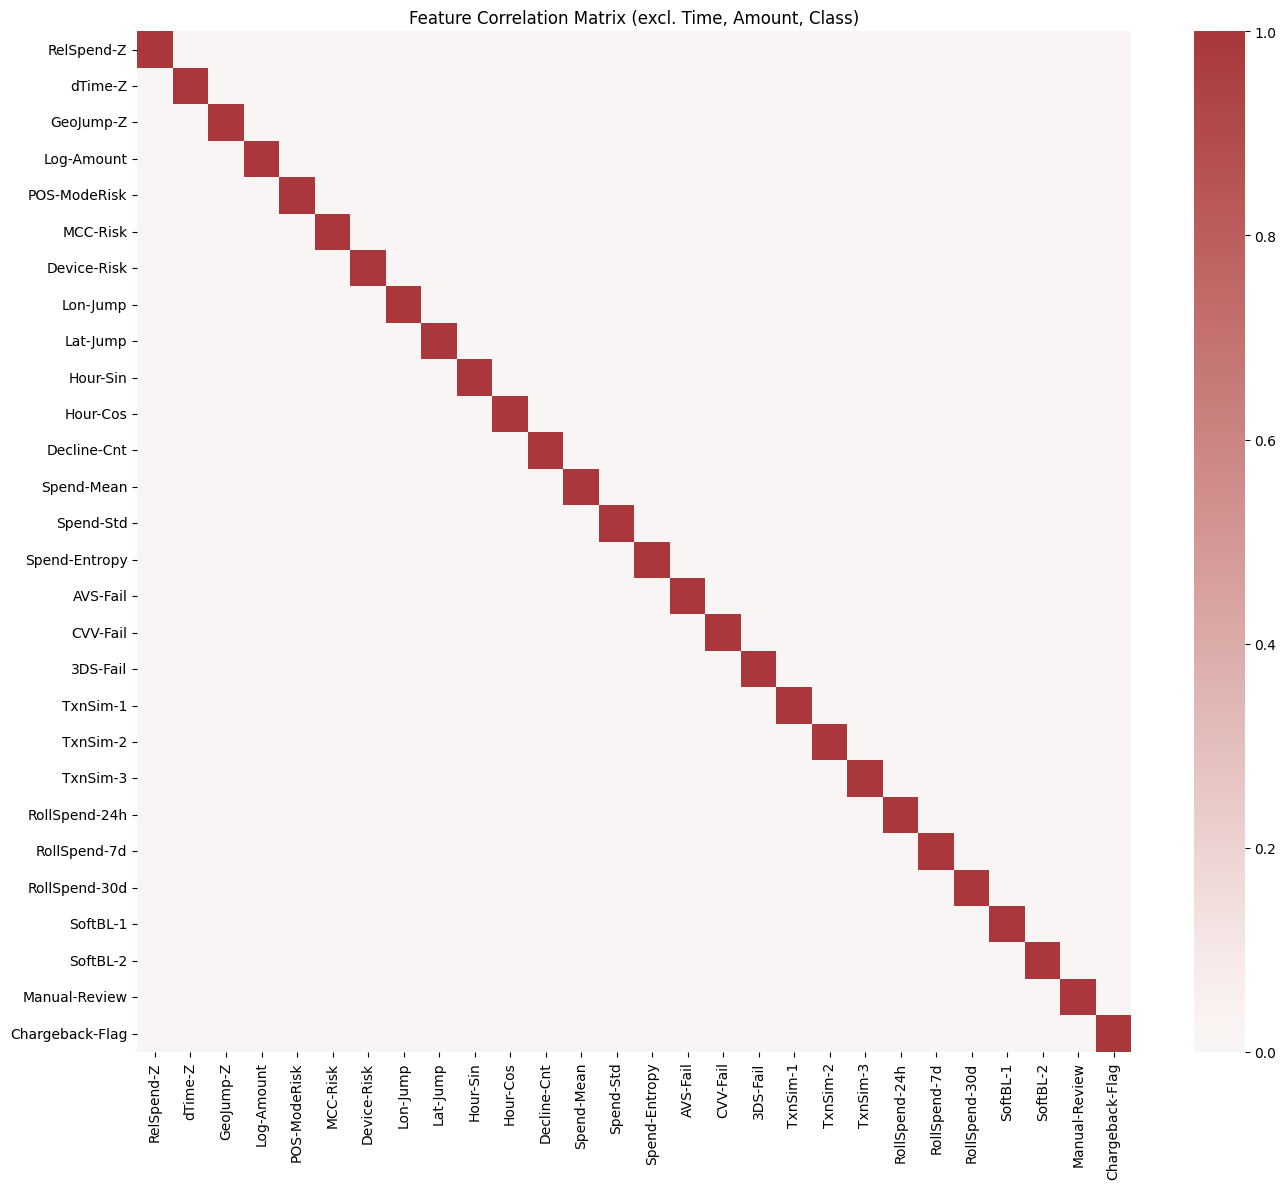

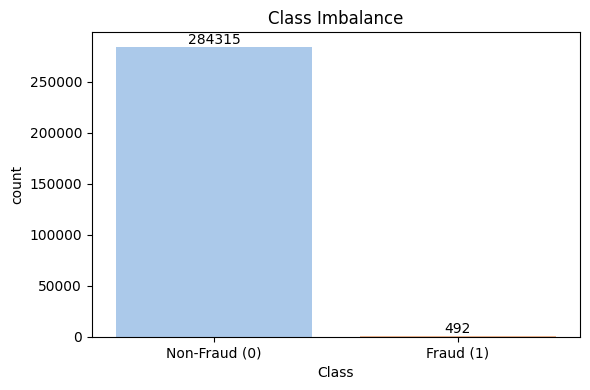

OptionError: No such keys(s): 'mode.use_inf_as_null'

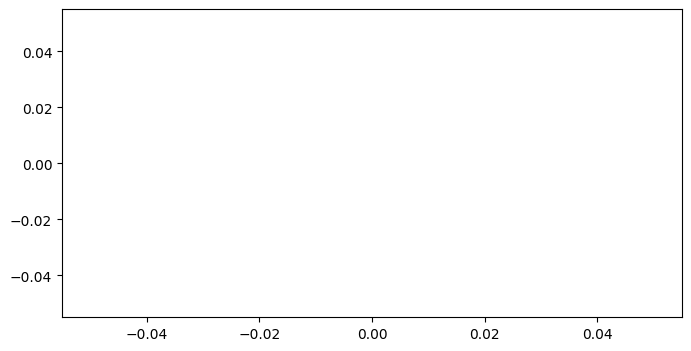

In [19]:
df['Class'] = df['Class'].astype(int)

# ─── 1) CORRELATION HEATMAP ────────────────────────────────────────────────
# Drop Time, Amount, Class before computing correlations
features = df.drop(columns=['Time', 'Amount', 'Class'])
corr = features.corr()

plt.figure(figsize=(14,12))
sns.heatmap(
    corr,
    cmap='vlag',
    center=0,
    annot=False,
    fmt='.2f',
    xticklabels=features.columns,
    yticklabels=features.columns
)
plt.title('Feature Correlation Matrix (excl. Time, Amount, Class)')
plt.tight_layout()
plt.show()

# ─── 2) CLASS IMBALANCE ───────────────────────────────────────────────────
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, palette='pastel')
plt.xticks([0,1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.title('Class Imbalance')
# annotate counts on bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom'
    )
plt.tight_layout()
plt.show()

# ─── 3) AMOUNT DISTRIBUTION ───────────────────────────────────────────────
# remove inf / -inf before plotting
amount = df['Amount'].replace([np.inf, -np.inf], np.nan).dropna()
plt.figure(figsize=(8,4))
sns.histplot(x=amount, bins=50, kde=True)
plt.xlabel('Transaction Amount')
plt.title('Amount Distribution')
plt.tight_layout()
plt.show()

# ─── 4) FRAUD RATE OVER TIME ───────────────────────────────────────────────
# bin the Time into quantiles, then compute fraud rate per bin
df['Time_bin'] = pd.qcut(df['Time'], q=50, duplicates='drop')
time_rate = df.groupby('Time_bin')['Class'].mean().reset_index()

plt.figure(figsize=(10,4))
sns.lineplot(x='Time_bin', y='Class', data=time_rate, marker='o')
plt.xticks(rotation=90)
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate Over Time')
plt.tight_layout()
plt.show()

In [16]:
df

,Time,RelSpend-Z,dTime-Z,GeoJump-Z,Log-Amount,POS-ModeRisk,MCC-Risk,Device-Risk,Lon-Jump,Lat-Jump,...,TxnSim-3,RollSpend-24h,RollSpend-7d,RollSpend-30d,SoftBL-1,SoftBL-2,Manual-Review,Chargeback-Flag,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
